In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import datasets
from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg19 import VGG19
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [2]:
# get VGG16 base model and define new input shape
vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=(32, 32, 3),
                                       weights='imagenet',
                                       include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [3]:
# add new dense layers at the top
x = tf.keras.layers.Flatten()(vgg16.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

In [4]:
# define and compile model
model = tf.keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [6]:
# COmpiling the model
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [8]:
#Train-validation-test split

#from sklearn.model_selection import train_test_split
#X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=.3)

X_val, y_val = X_train [:5000], y_train [:5000]
X_train, y_train = X_train[5000:], y_train[5000:]

In [9]:
#Onehot Encoding the labels.

from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical

In [10]:
#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [ ]:
# # Use the Image Data Generator to import the images from the dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
#Image Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

In [12]:
#Fitting the augmentation defined above to the data

train_generator.fit(X_train)
val_generator.fit(X_val)
test_ds = test_generator.fit(X_test)

In [13]:
#Learning Rate Annealer

# from tensorflow.keras.callbacks import EarlyStopping
# ES = EarlyStopping(monitor="val_loss", patience=1)

from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(   monitor='val_accuracy',   factor=.01,   patience=3,  min_lr=1e-5) 

In [14]:
# #Defining the parameters

# batch_size= 100
# epochs=100
# learn_rate=.001

In [15]:
history = model.fit(train_generator.flow(X_train, y_train, batch_size=32),
                    epochs = 100,
                    batch_size = 64,
                    validation_data = val_generator.flow(X_val, y_val, batch_size=32),
                    callbacks=[lrr])

Epoch 1/100
1407/1407 [==============================] - 60s 19ms/step - loss: 3.0130 - accuracy: 0.3076 - val_loss: 1.3826 - val_accuracy: 0.4970
Epoch 2/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.4060 - accuracy: 0.5112 - val_loss: 1.2598 - val_accuracy: 0.5588
Epoch 3/100
1407/1407 [==============================] - 26s 19ms/step - loss: 1.2916 - accuracy: 0.5554 - val_loss: 1.2337 - val_accuracy: 0.5794
Epoch 4/100
1407/1407 [==============================] - 26s 19ms/step - loss: 1.2397 - accuracy: 0.5767 - val_loss: 1.2311 - val_accuracy: 0.5792
Epoch 5/100
1407/1407 [==============================] - 26s 19ms/step - loss: 1.2051 - accuracy: 0.5916 - val_loss: 1.1693 - val_accuracy: 0.6068
Epoch 6/100
1407/1407 [==============================] - 26s 19ms/step - loss: 1.1913 - accuracy: 0.5929 - val_loss: 1.1759 - val_accuracy: 0.6058
Epoch 7/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.1481 - accuracy: 0.6107 - val_loss: 1

In [18]:
# history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size=batch_size), epochs = epochs, 
#                      steps_per_epoch = len(X_train)//batch_size, validation_data = val_generator.flow(X_val, y_val, batch_size=batch_size), validation_steps = 250, callbacks = [lrr], verbose=1)

In [19]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 3s 9ms/step - loss: 1.0852 - accuracy: 0.6551


[1.085191249847412, 0.6550999879837036]

In [20]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# import cnn_utils as utils
# from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

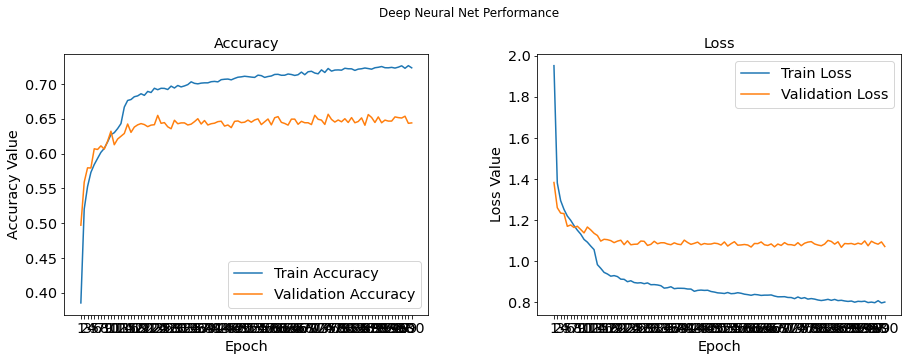

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,100+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [22]:
# # training and validation
# model.fit(train_generator.flow(X_train, y_train, batch_size=batch_size), epochs = epochs, 
#           steps_per_epoch = len(X_train)//batch_size, 
#           validation_data = val_generator.flow(X_val, y_val, batch_size=batch_size), 
#           validation_steps = 250, callbacks = [lrr], verbose=1)x_train, y_train,
#           batch_size=256,
#           epochs=10,
#           validation_data=(x_test, y_test))

# model.evaluate(x_test, y_test)